# Import Libraries

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Models and Preprocessing tools

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [223]:
try:
    import imblearn
except ImportError:
    !pip install imbalanced-learn -q
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

Set plot style for better visuals

In [224]:
sns.set_style('whitegrid')

# Load the dataset

In [225]:
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [226]:
df.shape

(10000, 10)

In [227]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Target,int64
Failure Type,object


# Exploratory Data Analysis (EDA)

## Check for missing values

In [228]:
print(df.isnull().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


## Descriptive statistics for numerical columns

In [229]:
df.drop(['UDI', 'Target'], axis=1).describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


# Data Visualization

## Distribution of Machine Failure

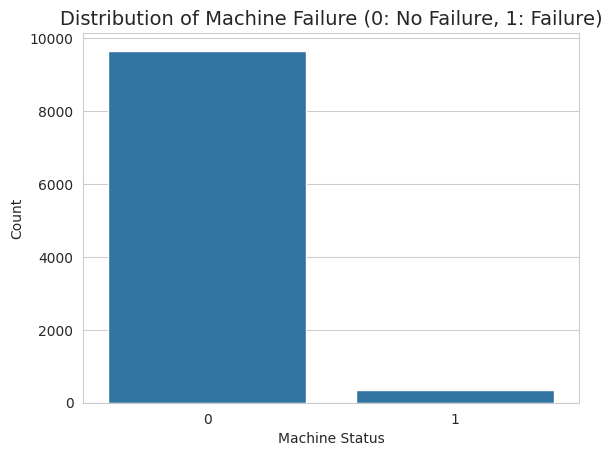

In [230]:
sns.countplot(x='Target', data=df)
plt.title('Distribution of Machine Failure (0: No Failure, 1: Failure)', fontsize=14)
plt.xlabel('Machine Status')
plt.ylabel('Count')
plt.show()

In [231]:
failure_rate = df['Target'].value_counts(normalize=True)[1] * 100
print(f"The dataset is highly imbalanced, with only {failure_rate:.2f}% of the data representing a machine failure.")

The dataset is highly imbalanced, with only 3.39% of the data representing a machine failure.


So, We need to fix the imbalanced data later.

## Distribution of Machine Types

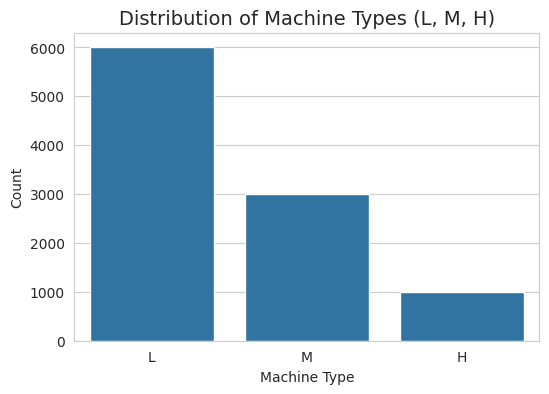

In [232]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Type', data=df, order=df['Type'].value_counts().index)
plt.title('Distribution of Machine Types (L, M, H)', fontsize=14)
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.show()

## Numerical Feature Distributions

In [233]:
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

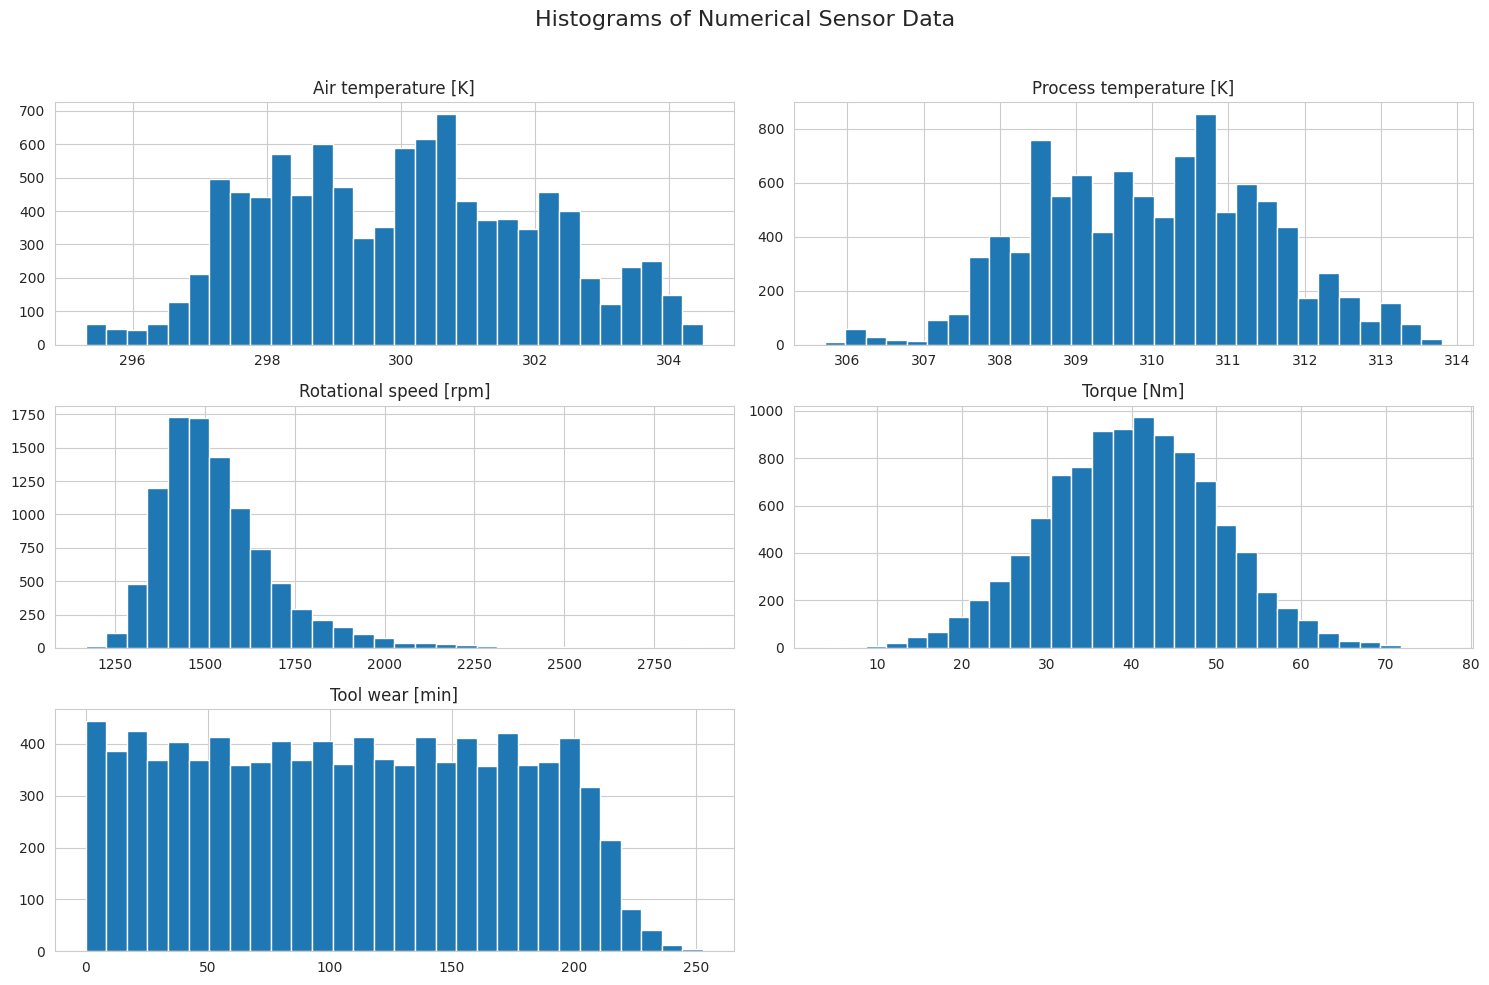

In [234]:
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Sensor Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Correlation Heatmap

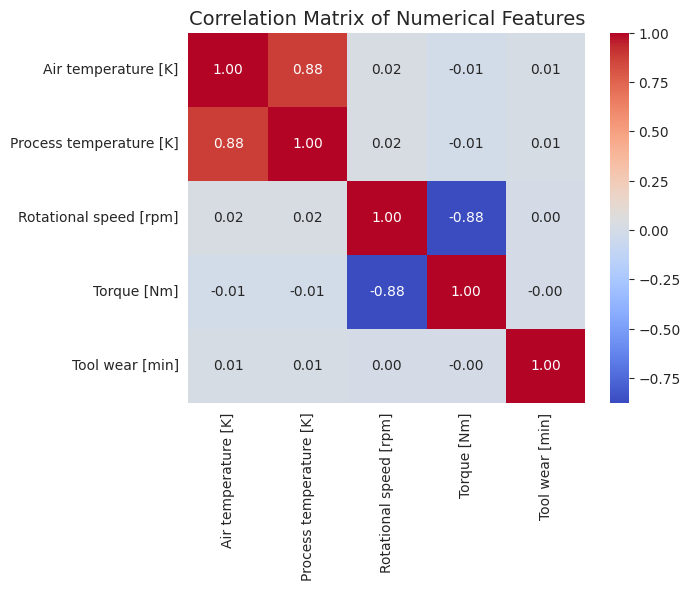

In [235]:
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.show()

## Box Plots for Numerical Features vs. Target

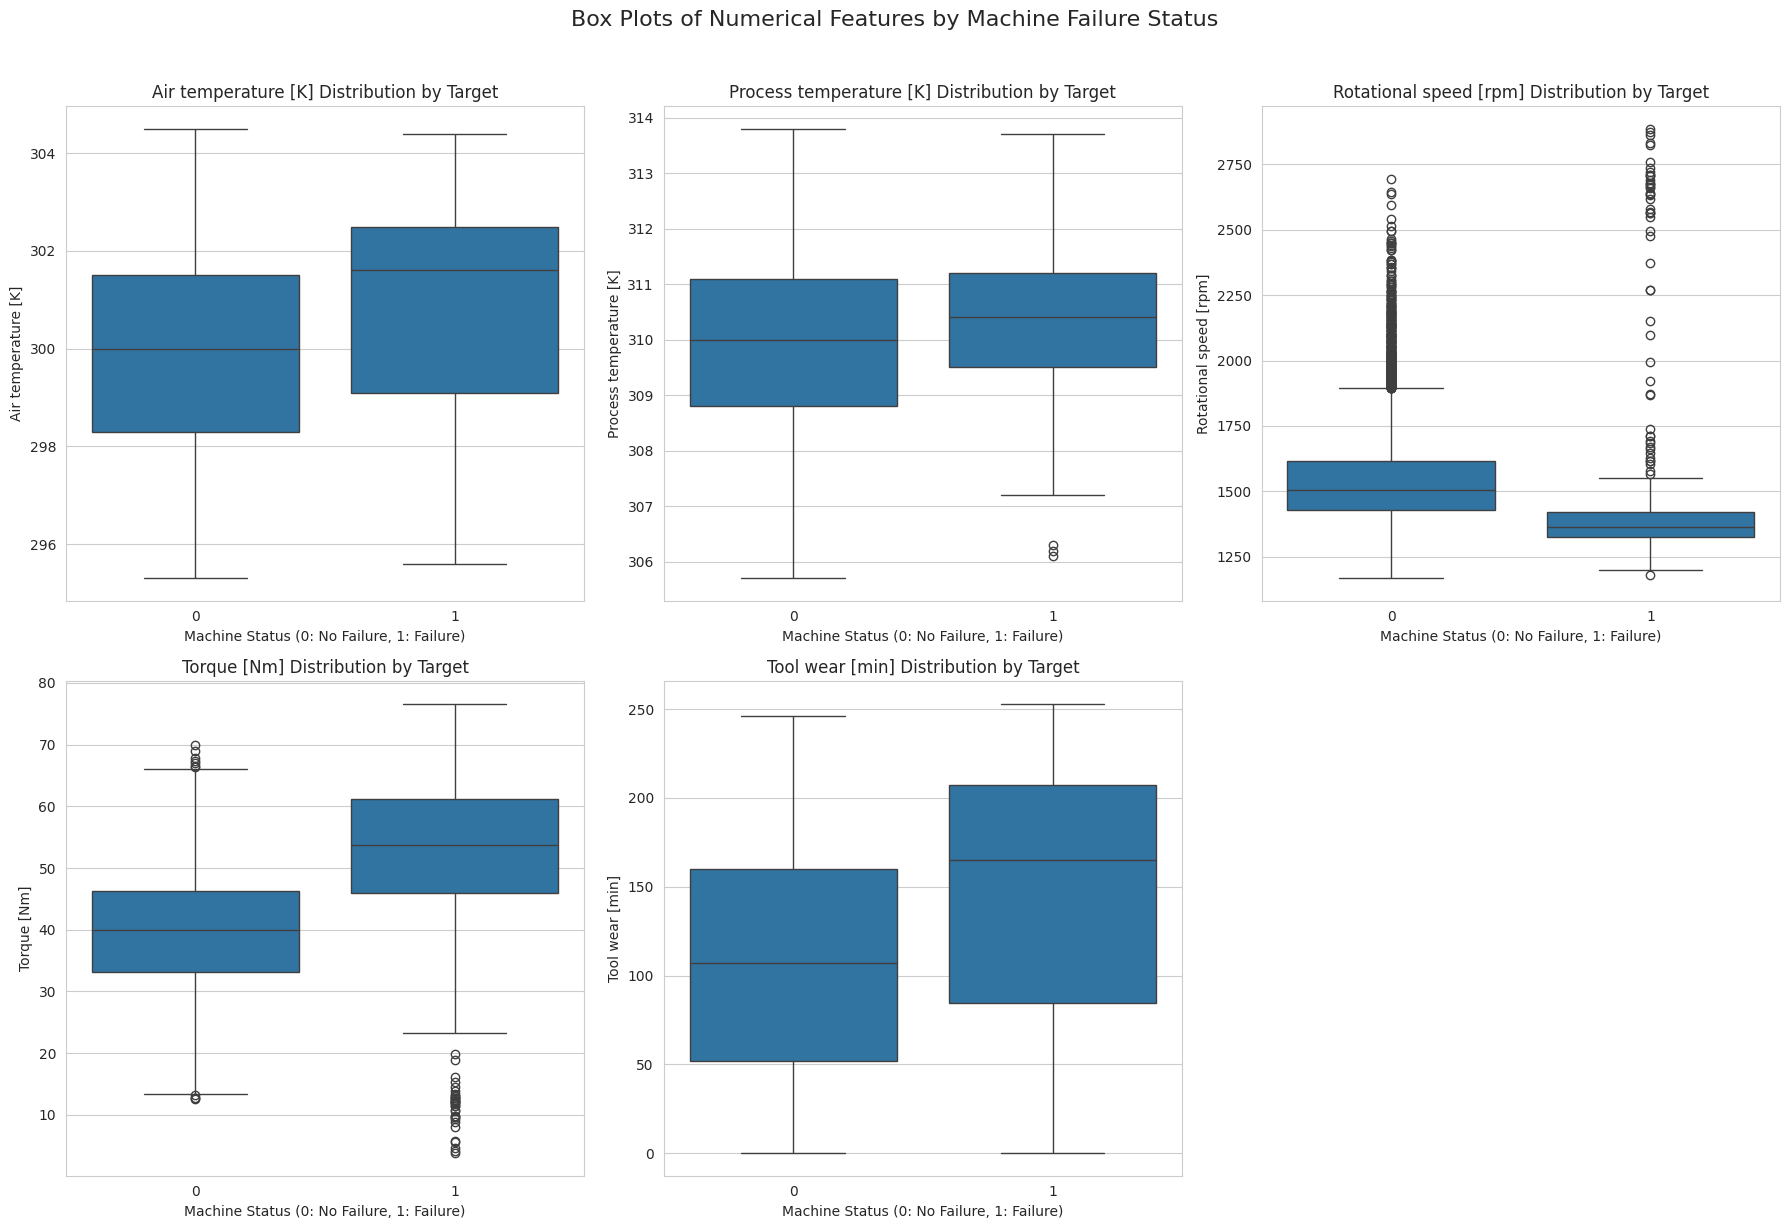

In [236]:
plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Target', y=feature, data=df)
    plt.title(f'{feature} Distribution by Target', fontsize=12)
    plt.xlabel('Machine Status (0: No Failure, 1: Failure)')
    plt.ylabel(feature)
plt.suptitle('Box Plots of Numerical Features by Machine Failure Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Define Features (X) and Target (y)

In [237]:
X = df.drop(['UDI', 'Product ID', 'Failure Type', 'Target'], axis=1)
y = df['Target']

In [238]:
categorical_features = ['Type']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

In [239]:
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print()
print(f"Identified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

Features (X) shape: (10000, 6)
Target (y) shape: (10000,)

Identified Numerical Features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Identified Categorical Features: ['Type']


# Split Data into Training and Test Sets

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

Data split into 8000 training samples and 2000 testing samples.


# Scale Numerical Features

In [241]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

StandardScaler()

In [242]:
X_train_scaled = scaler.transform(X_train[numerical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])

In [243]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test.index)

In [244]:
X_train_scaled_df.head(2)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
4058,0.998914,0.604282,-0.460607,0.718305,-0.843997
1221,-1.505194,-1.153260,-0.775574,0.638456,0.382263


In [245]:
X_test_scaled_df.head(2)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
2997,0.247681,-0.139294,-1.073963,2.265378,0.712410
4871,1.850310,1.618248,-0.145641,0.009646,0.429427


# Encode Categorical Features

In [246]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_features])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [247]:
X_train_encoded = encoder.transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

In [248]:
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

In [249]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

In [250]:
X_train_encoded_df.head(2)

,Type_H,Type_L,Type_M
4058,0.0,0.0,1.0
1221,0.0,0.0,1.0


In [251]:
X_test_encoded_df.head(2)

,Type_H,Type_L,Type_M
2997,0.0,1.0,0.0
4871,0.0,1.0,0.0


# Combine Processed Features

In [252]:
X_train_processed_df = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_test_processed_df = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

## Sanitize Column Names For XGBoost Model

In [253]:
def sanitize_name(name):
    return re.sub(r"[\[\]<]", "_", name)

X_train_processed_df.columns = [sanitize_name(col) for col in X_train_processed_df.columns]
X_test_processed_df.columns = [sanitize_name(col) for col in X_test_processed_df.columns]

final_feature_names_sanitized = X_train_processed_df.columns.tolist()
print("Sanitized feature names:", final_feature_names_sanitized)

X_train_processed = X_train_processed_df.values
X_test_processed = X_test_processed_df.values

print(f"Processed training features shape: {X_train_processed.shape}")
print(f"Processed test features shape: {X_test_processed.shape}")

Sanitized feature names: ['Air temperature _K_', 'Process temperature _K_', 'Rotational speed _rpm_', 'Torque _Nm_', 'Tool wear _min_', 'Type_H', 'Type_L', 'Type_M']
Processed training features shape: (8000, 8)
Processed test features shape: (2000, 8)


In [254]:
X_train_processed_df.head(2)

,Air temperature _K_,Process temperature _K_,Rotational speed _rpm_,Torque _Nm_,Tool wear _min_,Type_H,Type_L,Type_M
4058,0.998914,0.604282,-0.460607,0.718305,-0.843997,0.0,0.0,1.0
1221,-1.505194,-1.153260,-0.775574,0.638456,0.382263,0.0,0.0,1.0


In [255]:
X_test_processed_df.head(2)

,Air temperature _K_,Process temperature _K_,Rotational speed _rpm_,Torque _Nm_,Tool wear _min_,Type_H,Type_L,Type_M
2997,0.247681,-0.139294,-1.073963,2.265378,0.712410,0.0,1.0,0.0
4871,1.850310,1.618248,-0.145641,0.009646,0.429427,0.0,1.0,0.0


# Apply SMOTE to Fix Training Data Imbalance

In [256]:
smote = SMOTE(random_state=42)
print(f"Class distribution before SMOTE:\n{y_train.value_counts()}")

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print()
print(f"Shape after SMOTE: X_train={X_train_smote.shape}, y_train={y_train_smote.shape}")
print(f"Class distribution after SMOTE:\n{y_train_smote.value_counts()}")

Class distribution before SMOTE:
Target
0    7729
1     271
Name: count, dtype: int64

Shape after SMOTE: X_train=(15458, 8), y_train=(15458,)
Class distribution after SMOTE:
Target
0    7729
1    7729
Name: count, dtype: int64


# Model 1: Logistic Regression

## Training

In [257]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_smote, y_train_smote)

LogisticRegression(random_state=42)

## Overfitting Check

In [258]:
# Evaluate on Training Data
y_pred_train_lr = log_reg.predict(X_train_smote)
train_accuracy_lr = accuracy_score(y_train_smote, y_pred_train_lr)
print(f"Training Accuracy: {train_accuracy_lr:.4f}")

# Evaluate on Test Data
y_pred_test_lr = log_reg.predict(X_test_processed)
test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print(f"Test Accuracy: {test_accuracy_lr:.4f}")

if train_accuracy_lr > test_accuracy_lr + 0.05:
     print("Overfitting Detected (Significant drop in accuracy from train to test)")
else:
     print("Model generalization seems acceptable.")

Training Accuracy: 0.8182
Test Accuracy: 0.8295
Model generalization seems acceptable.


## Classification Report

In [259]:
print(classification_report(y_test, y_pred_test_lr, target_names=['No Failure', 'Failure']))

              precision    recall  f1-score   support

  No Failure       0.99      0.83      0.90      1932
     Failure       0.15      0.82      0.25        68

    accuracy                           0.83      2000
   macro avg       0.57      0.83      0.58      2000
weighted avg       0.96      0.83      0.88      2000



## Confusion Matrix

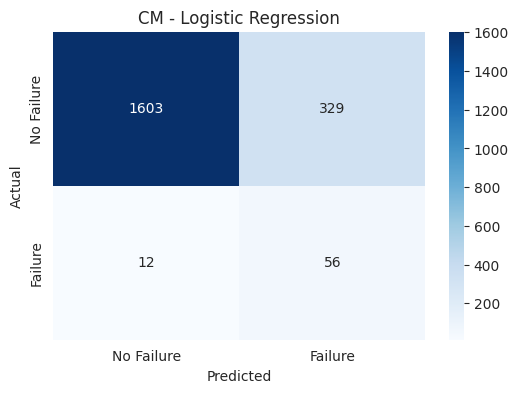

In [260]:
cm_lr = confusion_matrix(y_test, y_pred_test_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('CM - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model 2: Random Forest

## Training

In [261]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

## Overfitting Check

In [262]:
# Evaluate on Training Data
y_pred_train_rf = random_forest.predict(X_train_smote)
train_accuracy_rf = accuracy_score(y_train_smote, y_pred_train_rf)
print(f"Training Accuracy: {train_accuracy_rf:.4f}")

# Evaluate on Test Data
y_pred_test_rf = random_forest.predict(X_test_processed)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Test Accuracy (RF): {test_accuracy_rf:.4f}")

if train_accuracy_rf > test_accuracy_rf + 0.05:
     print("Overfitting Detected (Significant drop in accuracy from train to test)")
else:
     print("Model generalization seems acceptable.")

Training Accuracy: 1.0000
Test Accuracy (RF): 0.9665
Model generalization seems acceptable.


## Classification Report

In [263]:
print(classification_report(y_test, y_pred_test_rf, target_names=['No Failure', 'Failure']))

              precision    recall  f1-score   support

  No Failure       0.99      0.97      0.98      1932
     Failure       0.51      0.74      0.60        68

    accuracy                           0.97      2000
   macro avg       0.75      0.85      0.79      2000
weighted avg       0.97      0.97      0.97      2000



## Confusion Matrix

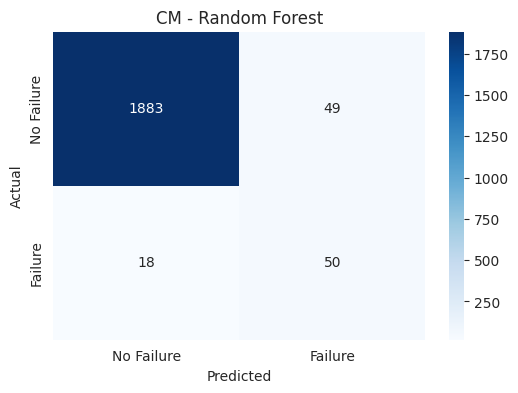

In [264]:
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('CM - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model 3: XGBoost

## Training

In [265]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Overfitting Check

In [266]:
# Evaluate on Training Data
y_pred_train_xgb = xgb_model.predict(X_train_smote)
train_accuracy_xgb = accuracy_score(y_train_smote, y_pred_train_xgb)
print(f"Training Accuracy: {train_accuracy_xgb:.4f}")

# Evaluate on Test Data
y_pred_test_xgb = xgb_model.predict(X_test_processed)
test_accuracy_xgb = accuracy_score(y_test, y_pred_test_xgb)
print(f"Test Accuracy: {test_accuracy_xgb:.4f}")

if train_accuracy_xgb > test_accuracy_xgb + 0.05:
     print("Overfitting Detected (Significant drop in accuracy from train to test)")
else:
     print("Model generalization seems acceptable.")

Training Accuracy: 0.9998
Test Accuracy: 0.9765
Model generalization seems acceptable.


## Classification Report

In [267]:
print(classification_report(y_test, y_pred_test_xgb, target_names=['No Failure', 'Failure']))

              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.99      1932
     Failure       0.62      0.81      0.70        68

    accuracy                           0.98      2000
   macro avg       0.81      0.90      0.84      2000
weighted avg       0.98      0.98      0.98      2000



## Confusion Matrix

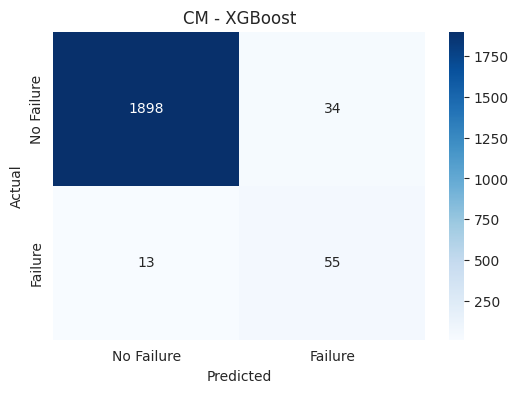

In [268]:
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb); plt.figure(figsize=(6, 4)); sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure']); plt.title('CM - XGBoost'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()

# Compare Model Recall & F1-Score

In [269]:
predictions_dict = {"Logistic Regression": y_pred_test_lr, "Random Forest": y_pred_test_rf, "XGBoost": y_pred_test_xgb}
metrics_scores = {}

for name, y_pred_model in predictions_dict.items():
    report = classification_report(y_test, y_pred_model, target_names=['No Failure', 'Failure'], output_dict=True)
    recall_failure = report['Failure']['recall']
    f1_failure = report['Failure']['f1-score']
    metrics_scores[name] = {'Recall': recall_failure, 'F1-Score': f1_failure}
    print(f"{name}: Recall = {recall_failure:.4f}, F1-Score = {f1_failure:.4f}")

Logistic Regression: Recall = 0.8235, F1-Score = 0.2472
Random Forest: Recall = 0.7353, F1-Score = 0.5988
XGBoost: Recall = 0.8088, F1-Score = 0.7006


**Reasoning for Model Selection**: Although Logistic Regression achieves the highest Recall
(detecting the most actual failures), XGBoost offers a significantly better F1-Score.
The F1-Score represents a better balance between catching failures (Recall) and ensuring
the failure predictions made are correct (Precision). For predictive maintenance, minimizing
false alarms (False Positives) while still catching most actual failures (High Recall) is
crucial for practical deployment. Therefore, XGBoost is selected as the better overall model
for this business problem due to its superior balance represented by the F1-Score.

In [270]:
best_model_name = "XGBoost"
best_model = xgb_model

print(f"Selected Best Model: {best_model_name}")
print(f"Metrics (Test Set): Recall = {metrics_scores[best_model_name]['Recall']:.4f}, F1-Score = {metrics_scores[best_model_name]['F1-Score']:.4f}")

Selected Best Model: XGBoost
Metrics (Test Set): Recall = 0.8088, F1-Score = 0.7006
